__To solve segmentation-model error:__
    
1. Go to `"./../anaconda3/Lib/site-packages/efficientnet/__init__.py"`
2. In the file change `keras.utils.generic_utils.get_custom_objects().update(custom_objects)` to `keras.utils.get_custom_objects().update(custom_objects)`

In [1]:
# pip install tensorflow-addons

In [2]:
import sys
import tensorflow as tf
import tensorflow_addons as tfa
import keras
import osgeo
import segmentation_models as sm

2024-04-06 20:08:47.735531: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-06 20:08:47.762312: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 20:08:47.762339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 20:08:47.763021: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-06 20:08:47.767831: I tensorflow/core/platform/cpu_feature_guar

Segmentation Models: using `keras` framework.


/home/kshitij/anaconda3/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
print(sys.version)
print(tf.__version__)
print(keras.__version__)
print(osgeo.__version__)
print(sm.__version__)

3.11.7 (main, Dec 15 2023, 18:12:31) [GCC 11.2.0]
2.15.0
2.15.0
3.6.2
1.0.1


In [4]:
import os
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from keras.applications import VGG16, Xception, ResNet152V2, EfficientNetV2M, InceptionV3
from tensorflow.keras.layers import Input, Activation, Flatten, Dense, Reshape, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Conv2DTranspose, UpSampling2D, concatenate, Dropout, BatchNormalization
from keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint

### Load train data

In [5]:
# dataset folder
data_dir = "./assignment2Data/trainingLabeled/"
time1_dir = data_dir + "time1/"
time2_dir = data_dir + "time2/"
label_dir = data_dir + "label/"

def load_data(time1_dir:str, time2_dir:str, label_dir:str):
    # ordered images and label
    time1_images = [] 
    time2_images = []
    labels = []

    # Get all files in the time1 directory
    files = os.listdir(time1_dir) # list
    img_files = [file for file in files if file.endswith('.png')]  # only PNG files
    
    for img_name in tqdm(img_files):
        time1_img_pth = os.path.join(time1_dir, img_name)
        time2_img_pth = os.path.join(time2_dir, img_name)
        label_pth = os.path.join(label_dir, img_name)
        
        # Load image & label
        img_t1 = Image.open(time1_img_pth)
        img_t2 = Image.open(time2_img_pth)
        lbl = Image.open(label_pth)
        
        # convert to ndarray
        img_t1 = np.array(img_t1)
        img_t2 = np.array(img_t2)
        lbl = np.array(lbl)

        # scale each img to 0-1 range; normalizing each channels independently
        scaler = MinMaxScaler()
        num_channels = img_t1.shape[-1]
        img_t1 = scaler.fit_transform(img_t1.reshape(-1, num_channels)).reshape(img_t1.shape) # each column represent a band
        img_t2 = scaler.fit_transform(img_t2.reshape(-1, num_channels)).reshape(img_t2.shape) # each column represent a band
    
    
        time1_images.append(img_t1)
        time2_images.append(img_t2)
        labels.append(lbl)
        
    return time1_images, time2_images, labels

#### train set

100%|█████████████████████████████████████████| 120/120 [00:03<00:00, 32.58it/s]


120 120 120
2 [  0 255]


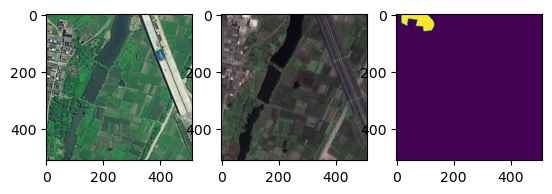

In [6]:
time1_images, time2_images, labels = load_data(time1_dir, time2_dir, label_dir)
print(len(time1_images), len(time2_images), len(labels))
# To find unique values of each all pixels in all images
unique_values = np.unique(np.array(labels).flatten())
print(len(unique_values), unique_values)

idx = random.randint(0, len(time1_images))
# Plot for image t1
plt.subplot(1, 3, 1)
plt.imshow(time1_images[idx])
# Plot for image t2
plt.subplot(1, 3, 2)
plt.imshow(time2_images[idx])
# Plot for label
plt.subplot(1, 3, 3)
plt.imshow(labels[idx])
plt.show()

In [7]:
# convert pixel values to label
for i in tqdm(range(len(labels))):
    labels[i][labels[i] == 0] = 0 # Replace 0 with 0
    labels[i][labels[i] == 255] = 1 # Replace 255 with 1

# To find unique values of each all pixels in all images
unique_values = np.unique(np.array(labels).flatten())
print(len(unique_values), unique_values)

100%|███████████████████████████████████████| 120/120 [00:00<00:00, 7302.59it/s]


2 [0 1]


In [8]:
# convert to array
time1_images, time2_images, label_array = np.array(time1_images), np.array(time2_images), np.array(labels)
print(time1_images.shape, time2_images.shape, label_array.shape)

(120, 512, 512, 3) (120, 512, 512, 3) (120, 512, 512)


#### test set

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 33.18it/s]


100 100 100
2 [  0 255]


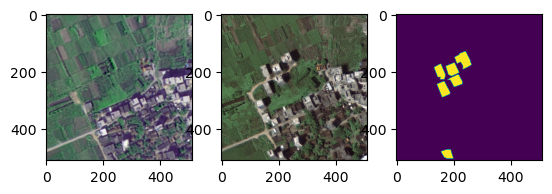

In [9]:
# dataset folder
data_dir = "./assignment2Data/testKnownLabel/"
time1_dir = data_dir + "time1/"
time2_dir = data_dir + "time2/"
label_dir = data_dir + "label/"

test1_images, test2_images, test_labels = load_data(time1_dir, time2_dir, label_dir)
print(len(test1_images), len(test2_images), len(test_labels))
# To find unique values of each all pixels in all images
unique_values_test = np.unique(np.array(test_labels).flatten())
print(len(unique_values_test), unique_values_test)

idx = random.randint(0, len(test1_images))
# Plot for image t1
plt.subplot(1, 3, 1)
plt.imshow(test1_images[idx])
# Plot for image t2
plt.subplot(1, 3, 2)
plt.imshow(test2_images[idx])
# Plot for label
plt.subplot(1, 3, 3)
plt.imshow(test_labels[idx])
plt.show()

In [10]:
# convert pixel values to label
for i in tqdm(range(len(test_labels))):
    test_labels[i][test_labels[i] == 0] = 0 # Replace 0 with 0
    test_labels[i][test_labels[i] == 255] = 1 # Replace 255 with 1

# To find unique values of each all pixels in all images
unique_values_test = np.unique(np.array(test_labels).flatten())
print(len(unique_values_test), unique_values_test)

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 6471.29it/s]

2 [0 1]


In [11]:
# convert to array
test1_images, test2_images, test_labels = np.array(test1_images), np.array(test2_images), np.array(test_labels)
print(test1_images.shape, test2_images.shape, test_labels.shape)

(100, 512, 512, 3) (100, 512, 512, 3) (100, 512, 512)


### Model

In [12]:
def cd_model(base_model, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=3):
    # Freeze base_model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Get convolutional layers
    
    # to get only encoder block output 
    conv_layers_index = [] # encoder_layers_idx
    for index, layer in enumerate(base_model.layers):   # Iterate through the layers of the model
        if isinstance(layer, keras.layers.Concatenate):
            if 'decoder_stage' in layer.name:
                # Get the inbound nodes of the layer
                inbound_nodes = layer._inbound_nodes
                # Extract the list of input layers from the inbound nodes
                input_layers = [input_layer.name for input_layer in inbound_nodes[0].input_tensors]
                # Get the layer name at index 1 i.e from encoder
                second_layer_name = input_layers[1].split('/')[0] 
                # Get the index of the second layer in the model's layers list
                second_layer_index = [i for i, layer in enumerate(base_model.layers) if layer.name == second_layer_name][0]
                conv_layers_index.append(second_layer_index)
                
    print(len(conv_layers_index))

    def feature_extraction_model(base_model, i):
        x = base_model.layers[i].output
        return Model(inputs=base_model.input, outputs=x)

    # Define upsampling block
    def mlp_upsampling_block(x, filters, IMG_HEIGHT, IMG_WIDTH):
        x = Conv2D(16, (3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal', padding='valid')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Conv2D(3, (3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_normal', padding='valid')(x)
        x = BatchNormalization()(x)

        x = Flatten()(x)
        x = Dense(128, activation='relu')(x) # output activations no so that output shape should be H/8,W/8
        x = Dense(filters * IMG_HEIGHT//8 * IMG_WIDTH//8, activation='relu')(x)
        x = Reshape((IMG_HEIGHT//8, IMG_WIDTH//8, filters))(x)
        return x


    # Define a model to compute feature map differences at each convolutional layer
    def feature_map_difference_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
        input1 = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
        input2 = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))    
        
        feature_differences = []

        # Compute feature map differences at each convolutional layer; return shape: (H/4, W/4, channels)
        for i in conv_layers_index:
            feature_extractor = feature_extraction_model(base_model, i)
            features1 = feature_extractor(input1)
            features2 = feature_extractor(input2)
            difference = tf.math.abs(features2 - features1)

            # Upsample the difference to shape (H/8, W/8, channels)
            filters = 3 # difference.shape[-1]
            upsampled_difference = mlp_upsampling_block(difference, filters, IMG_HEIGHT, IMG_WIDTH)
            # print(upsampled_difference.shape)

            feature_differences.append(upsampled_difference)

        # Stack the differences
        x = tf.concat(feature_differences, axis=-1)

        x = UpSampling2D(size=(8, 8))(x) # to shape (H, W, channels) 

        x = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer=RandomNormal(stddev=0.02))(x)
        x = tfa.layers.InstanceNormalization(axis=-1)(x)
        x = Activation("relu")(x)
        x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)

        n_classes = 1 # as each pixel is eith 0 or 1 in label i.e has no channel dimen as shape is (512,512)
        outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(x)

        return Model(inputs=[input1, input2], outputs=outputs)

    # Create change detection model
    model = feature_map_difference_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    
    return model

In [13]:
# Load pre-trained model
# encoder_freeze=False i.e training Encoder with imagenet as initial weights; as only encoder is needed for feature extraction
BACKBONE = 'resnet34'
base_model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes= 1, activation='softmax',
               encoder_freeze=False, decoder_filters=(256, 128, 64, 32, 16), decoder_use_batchnorm=True)

model = cd_model(base_model, IMG_HEIGHT=time1_images.shape[1], IMG_WIDTH=time1_images.shape[2], IMG_CHANNELS=time1_images.shape[3])

2024-04-06 20:08:57.110068: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-06 20:08:57.130202: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-06 20:08:57.130328: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

4


In [14]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 model_2 (Functional)        (None, None, None, 256)      8182985   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 model_3 (Functional)        (None, None, None, 128)      1354953   ['input_1[0][0]',       

In [15]:
# Compile the model
#Define loss, metrics and optimizer to be used for training
class_weights = [0.4,0.6]
dice_loss = sm.losses.DiceLoss(class_weights=class_weights) 
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  

metrics = ['accuracy', sm.metrics.FScore(class_weights=class_weights)]

lr = 0.001
optim = keras.optimizers.Adam(lr)

model.compile(optimizer=optim, loss= total_loss, metrics=metrics)

In [16]:
model_checkpoint_folder = './model_checkpoint/'
os.makedirs(model_checkpoint_folder, exist_ok = True)

filename = f'cd_resnet34.hdf5'
print('Model will be saved in directory : ', model_checkpoint_folder)
fname = os.path.join(model_checkpoint_folder, filename)

# Set callback functions to early stop training and save the best model so far
callbacks = [ModelCheckpoint(filepath = fname, monitor = 'f1-score', mode='max', save_best_only = True, verbose = 1)]    

# preprocess input
preprocess_input = sm.get_preprocessing(BACKBONE)
X_train1 = preprocess_input(time1_images)
X_train2 = preprocess_input(time2_images)
print(X_train1.shape, X_train2.shape)

# Train the model
history_resnet34 = model.fit([X_train1, X_train2], label_array.astype('float32'), validation_split=0.1, shuffle=True, epochs=300, batch_size=8, callbacks = callbacks)

Model will be saved in directory :  ./model_checkpoint/
(120, 512, 512, 3) (120, 512, 512, 3)
Epoch 1/300


2024-04-06 20:09:03.942048: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-06 20:09:04.469275: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-06 20:09:04.484433: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-06 20:09:04.553183: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-06 20:09:10.299840: I external/local_xla/xla/service/service.cc:168] XLA service 0x76bcf3226520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-06 20:09:10.299857: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 407

14/14 [==============================] - ETA: 0s - loss: 1.0475 - accuracy: 0.7465 - f1-score: 0.0580
Epoch 1: f1-score improved from -inf to 0.05804, saving model to ./model_checkpoint/cd_resnet34.hdf5


/home/kshitij/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 37s 1s/step - loss: 1.0475 - accuracy: 0.7465 - f1-score: 0.0580 - val_loss: 0.9719 - val_accuracy: 0.8606 - val_f1-score: 0.0968
Epoch 2/300
14/14 [==============================] - ETA: 0s - loss: 0.9759 - accuracy: 0.9273 - f1-score: 0.0556
Epoch 2: f1-score did not improve from 0.05804
14/14 [==============================] - 4s 317ms/step - loss: 0.9759 - accuracy: 0.9273 - f1-score: 0.0556 - val_loss: 0.9580 - val_accuracy: 0.8606 - val_f1-score: 0.0912
Epoch 3/300
14/14 [==============================] - ETA: 0s - loss: 0.9603 - accuracy: 0.9300 - f1-score: 0.0659
Epoch 3: f1-score improved from 0.05804 to 0.06586, saving model to ./model_checkpoint/cd_resnet34.hdf5
14/14 [==============================] - 5s 339ms/step - loss: 0.9603 - accuracy: 0.9300 - f1-score: 0.0659 - val_loss: 0.9619 - val_accuracy: 0.8606 - val_f1-score: 0.0940
Epoch 4/300
14/14 [==============================] - ETA: 0s - loss: 0.9357 - accuracy: 0.9285 - f1-scor

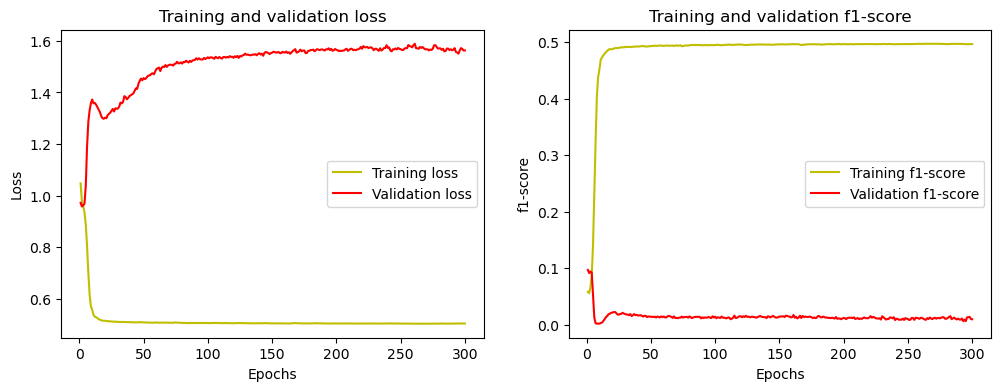

In [17]:
def acc_loss_plot(history):
    # Set the size of the figure
    plt.figure(figsize=(12, 4)) 

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation IoU
    plt.subplot(1, 2, 2)
    acc = history.history['f1-score']
    val_acc = history.history['val_f1-score']
    plt.plot(epochs, acc, 'y', label='Training f1-score')
    plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
    plt.title('Training and validation f1-score')
    plt.xlabel('Epochs')
    plt.ylabel('f1-score')
    plt.legend()

    plt.show()

acc_loss_plot(history_resnet34)

In [18]:
# load the best model
model = tf.keras.models.load_model(fname, compile = False)

# preprocess input
preprocess_input = sm.get_preprocessing(BACKBONE)
X_test1 = preprocess_input(test1_images)
X_test2 = preprocess_input(test2_images)
print(X_test1.shape, X_test2.shape)

y_pred = model.predict([X_test1, X_test2], batch_size=8, verbose=2).squeeze(axis=-1)
# Convert predicted score to binary labels (0 or 1)
y_pred = (y_pred > 0.5).astype(int)

# Flatten arrays
y_true = test_labels.flatten()
y_pred = y_pred.flatten()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1]) # 1st row & column is class 0 & 2nd row & column is class 1

# Calculate metrics for class 1(positive) and class 0(negative)
tp = conf_matrix[1, 1]
fn = conf_matrix[1, 0]
fp = conf_matrix[0, 1]
tn = conf_matrix[0, 0]

# Compute sensitivity (true positive rate) for class 1
sensitivity = tp / (tp + fn)

# Compute specificity (true negative rate) for class 1
specificity = tn / (tn + fp)

# Compute overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred)

# Compute F1 score
f1 = f1_score(y_true, y_pred)

print()
print("Sensitivity (TPR) for class 1:", round(sensitivity, 4))
print("Specificity (TNR) for class 1:", round(specificity, 4))
print("Overall Accuracy:", round(overall_accuracy, 4))
print("F1 Score:", round(f1, 4))

(100, 512, 512, 3) (100, 512, 512, 3)
13/13 - 2s - 2s/epoch - 191ms/step

Sensitivity (TPR) for class 1: 0.0169
Specificity (TNR) for class 1: 0.9859
Overall Accuracy: 0.9189
F1 Score: 0.028


#### Seresnet34

In [19]:
BACKBONE = 'seresnet34'
base_model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes= 1, activation='softmax',
               encoder_freeze=False, decoder_filters=(256, 128, 64, 32, 16), decoder_use_batchnorm=True)

model = cd_model(base_model, IMG_HEIGHT=time1_images.shape[1], IMG_WIDTH=time1_images.shape[2], IMG_CHANNELS=time1_images.shape[3])

4


In [20]:
# Compile the model
class_weights = [0.4,0.6]
dice_loss = sm.losses.DiceLoss(class_weights=class_weights) 
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  

metrics = ['accuracy', sm.metrics.FScore(class_weights=class_weights)]

lr = 0.001
optim = keras.optimizers.Adam(lr)

model.compile(optimizer=optim, loss= total_loss, metrics=metrics)

In [21]:
model_checkpoint_folder = './model_checkpoint/'
os.makedirs(model_checkpoint_folder, exist_ok = True)

filename = f'cd_seresnet34.hdf5'
print('Model will be saved in directory : ', model_checkpoint_folder)
fname = os.path.join(model_checkpoint_folder, filename)

# Set callback functions to early stop training and save the best model so far
callbacks = [ModelCheckpoint(filepath = fname, monitor = 'f1-score', mode='max', save_best_only = True, verbose = 1)]    

# preprocess input
preprocess_input = sm.get_preprocessing(BACKBONE)
X_train1 = preprocess_input(time1_images)
X_train2 = preprocess_input(time2_images)
print(X_train1.shape, X_train2.shape)

# Train the model
history_seresnet34 = model.fit([X_train1, X_train2], label_array.astype('float32'), validation_split=0.1, shuffle=True, epochs=300, batch_size=8, callbacks = callbacks)

Model will be saved in directory :  ./model_checkpoint/
(120, 512, 512, 3) (120, 512, 512, 3)
Epoch 1/300


2024-04-06 20:31:56.972075: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_13/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


14/14 [==============================] - ETA: 0s - loss: 1.0451 - accuracy: 0.8028 - f1-score: 0.0524
Epoch 1: f1-score improved from -inf to 0.05241, saving model to ./model_checkpoint/cd_seresnet34.hdf5


/home/kshitij/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 15s 492ms/step - loss: 1.0451 - accuracy: 0.8028 - f1-score: 0.0524 - val_loss: 0.9619 - val_accuracy: 0.8604 - val_f1-score: 0.0877
Epoch 2/300
14/14 [==============================] - ETA: 0s - loss: 0.9818 - accuracy: 0.9207 - f1-score: 0.0575
Epoch 2: f1-score improved from 0.05241 to 0.05750, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 346ms/step - loss: 0.9818 - accuracy: 0.9207 - f1-score: 0.0575 - val_loss: 0.9616 - val_accuracy: 0.8606 - val_f1-score: 0.0850
Epoch 3/300
14/14 [==============================] - ETA: 0s - loss: 0.9540 - accuracy: 0.9160 - f1-score: 0.0770
Epoch 3: f1-score improved from 0.05750 to 0.07702, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 354ms/step - loss: 0.9540 - accuracy: 0.9160 - f1-score: 0.0770 - val_loss: 0.9807 - val_accuracy: 0.8604 - val_f1-score: 0.0747
Epoch 4/300
14/14 [==============================] - ETA: 0s - loss: 0.8712 - accuracy: 0.9301 - f1-score: 0.1652
Epoch 4: f1-score improved from 0.07702 to 0.16516, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 355ms/step - loss: 0.8712 - accuracy: 0.9301 - f1-score: 0.1652 - val_loss: 1.1769 - val_accuracy: 0.8603 - val_f1-score: 0.0162
Epoch 5/300
14/14 [==============================] - ETA: 0s - loss: 0.7143 - accuracy: 0.9634 - f1-score: 0.3183
Epoch 5: f1-score improved from 0.16516 to 0.31831, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 349ms/step - loss: 0.7143 - accuracy: 0.9634 - f1-score: 0.3183 - val_loss: 1.3275 - val_accuracy: 0.8605 - val_f1-score: 0.0030
Epoch 6/300
14/14 [==============================] - ETA: 0s - loss: 0.6288 - accuracy: 0.9777 - f1-score: 0.3970
Epoch 6: f1-score improved from 0.31831 to 0.39698, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 347ms/step - loss: 0.6288 - accuracy: 0.9777 - f1-score: 0.3970 - val_loss: 1.3270 - val_accuracy: 0.8587 - val_f1-score: 0.0048
Epoch 7/300
14/14 [==============================] - ETA: 0s - loss: 0.5651 - accuracy: 0.9892 - f1-score: 0.4489
Epoch 7: f1-score improved from 0.39698 to 0.44889, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 353ms/step - loss: 0.5651 - accuracy: 0.9892 - f1-score: 0.4489 - val_loss: 1.3507 - val_accuracy: 0.8604 - val_f1-score: 0.0013
Epoch 8/300
14/14 [==============================] - ETA: 0s - loss: 0.5423 - accuracy: 0.9932 - f1-score: 0.4668
Epoch 8: f1-score improved from 0.44889 to 0.46677, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 354ms/step - loss: 0.5423 - accuracy: 0.9932 - f1-score: 0.4668 - val_loss: 1.3521 - val_accuracy: 0.8605 - val_f1-score: 7.3739e-04
Epoch 9/300
14/14 [==============================] - ETA: 0s - loss: 0.5330 - accuracy: 0.9948 - f1-score: 0.4742
Epoch 9: f1-score improved from 0.46677 to 0.47420, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 348ms/step - loss: 0.5330 - accuracy: 0.9948 - f1-score: 0.4742 - val_loss: 1.3586 - val_accuracy: 0.8606 - val_f1-score: 4.7015e-04
Epoch 10/300
14/14 [==============================] - ETA: 0s - loss: 0.5308 - accuracy: 0.9955 - f1-score: 0.4756
Epoch 10: f1-score improved from 0.47420 to 0.47557, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 352ms/step - loss: 0.5308 - accuracy: 0.9955 - f1-score: 0.4756 - val_loss: 1.3592 - val_accuracy: 0.8606 - val_f1-score: 3.2149e-04
Epoch 11/300
14/14 [==============================] - ETA: 0s - loss: 0.5244 - accuracy: 0.9959 - f1-score: 0.4810
Epoch 11: f1-score improved from 0.47557 to 0.48099, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 348ms/step - loss: 0.5244 - accuracy: 0.9959 - f1-score: 0.4810 - val_loss: 1.3578 - val_accuracy: 0.8606 - val_f1-score: 2.5649e-04
Epoch 12/300
14/14 [==============================] - ETA: 0s - loss: 0.5210 - accuracy: 0.9964 - f1-score: 0.4838
Epoch 12: f1-score improved from 0.48099 to 0.48380, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 347ms/step - loss: 0.5210 - accuracy: 0.9964 - f1-score: 0.4838 - val_loss: 1.3566 - val_accuracy: 0.8605 - val_f1-score: 4.0615e-04
Epoch 13/300
14/14 [==============================] - ETA: 0s - loss: 0.5192 - accuracy: 0.9967 - f1-score: 0.4846
Epoch 13: f1-score improved from 0.48380 to 0.48463, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 345ms/step - loss: 0.5192 - accuracy: 0.9967 - f1-score: 0.4846 - val_loss: 1.3509 - val_accuracy: 0.8604 - val_f1-score: 4.5530e-04
Epoch 14/300
14/14 [==============================] - ETA: 0s - loss: 0.5174 - accuracy: 0.9970 - f1-score: 0.4863
Epoch 14: f1-score improved from 0.48463 to 0.48632, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 352ms/step - loss: 0.5174 - accuracy: 0.9970 - f1-score: 0.4863 - val_loss: 1.3502 - val_accuracy: 0.8604 - val_f1-score: 5.7761e-04
Epoch 15/300
14/14 [==============================] - ETA: 0s - loss: 0.5158 - accuracy: 0.9972 - f1-score: 0.4873
Epoch 15: f1-score improved from 0.48632 to 0.48728, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 346ms/step - loss: 0.5158 - accuracy: 0.9972 - f1-score: 0.4873 - val_loss: 1.3509 - val_accuracy: 0.8605 - val_f1-score: 4.4008e-04
Epoch 16/300
14/14 [==============================] - ETA: 0s - loss: 0.5146 - accuracy: 0.9974 - f1-score: 0.4884
Epoch 16: f1-score improved from 0.48728 to 0.48836, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 350ms/step - loss: 0.5146 - accuracy: 0.9974 - f1-score: 0.4884 - val_loss: 1.3451 - val_accuracy: 0.8605 - val_f1-score: 5.2955e-04
Epoch 17/300
14/14 [==============================] - ETA: 0s - loss: 0.5132 - accuracy: 0.9976 - f1-score: 0.4896
Epoch 17: f1-score improved from 0.48836 to 0.48961, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 351ms/step - loss: 0.5132 - accuracy: 0.9976 - f1-score: 0.4896 - val_loss: 1.3476 - val_accuracy: 0.8605 - val_f1-score: 4.6938e-04
Epoch 18/300
14/14 [==============================] - ETA: 0s - loss: 0.5124 - accuracy: 0.9978 - f1-score: 0.4900
Epoch 18: f1-score improved from 0.48961 to 0.49003, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 348ms/step - loss: 0.5124 - accuracy: 0.9978 - f1-score: 0.4900 - val_loss: 1.3491 - val_accuracy: 0.8604 - val_f1-score: 6.6553e-04
Epoch 19/300
14/14 [==============================] - ETA: 0s - loss: 0.5120 - accuracy: 0.9979 - f1-score: 0.4900
Epoch 19: f1-score did not improve from 0.49003
14/14 [==============================] - 4s 317ms/step - loss: 0.5120 - accuracy: 0.9979 - f1-score: 0.4900 - val_loss: 1.3592 - val_accuracy: 0.8603 - val_f1-score: 7.2223e-04
Epoch 20/300
14/14 [==============================] - ETA: 0s - loss: 0.5115 - accuracy: 0.9979 - f1-score: 0.4907
Epoch 20: f1-score improved from 0.49003 to 0.49065, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 346ms/step - loss: 0.5115 - accuracy: 0.9979 - f1-score: 0.4907 - val_loss: 1.3658 - val_accuracy: 0.8606 - val_f1-score: 5.1191e-04
Epoch 21/300
14/14 [==============================] - ETA: 0s - loss: 0.5122 - accuracy: 0.9978 - f1-score: 0.4901
Epoch 21: f1-score did not improve from 0.49065
14/14 [==============================] - 4s 318ms/step - loss: 0.5122 - accuracy: 0.9978 - f1-score: 0.4901 - val_loss: 1.3748 - val_accuracy: 0.8603 - val_f1-score: 9.4392e-04
Epoch 22/300
14/14 [==============================] - ETA: 0s - loss: 0.5118 - accuracy: 0.9979 - f1-score: 0.4906
Epoch 22: f1-score did not improve from 0.49065
14/14 [==============================] - 4s 319ms/step - loss: 0.5118 - accuracy: 0.9979 - f1-score: 0.4906 - val_loss: 1.3729 - val_accuracy: 0.8603 - val_f1-score: 8.1364e-04
Epoch 23/300
14/14 [==============================] - ETA: 0s - loss: 0.5118 - accuracy: 0.9980 - f1-score: 0.4904
Epoch 23: f1-score did not i

14/14 [==============================] - 5s 349ms/step - loss: 0.5111 - accuracy: 0.9981 - f1-score: 0.4910 - val_loss: 1.3871 - val_accuracy: 0.8601 - val_f1-score: 0.0013
Epoch 26/300
14/14 [==============================] - ETA: 0s - loss: 0.5113 - accuracy: 0.9981 - f1-score: 0.4901
Epoch 26: f1-score did not improve from 0.49100
14/14 [==============================] - 4s 316ms/step - loss: 0.5113 - accuracy: 0.9981 - f1-score: 0.4901 - val_loss: 1.3889 - val_accuracy: 0.8602 - val_f1-score: 0.0011
Epoch 27/300
14/14 [==============================] - ETA: 0s - loss: 0.5103 - accuracy: 0.9982 - f1-score: 0.4915
Epoch 27: f1-score improved from 0.49100 to 0.49152, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 349ms/step - loss: 0.5103 - accuracy: 0.9982 - f1-score: 0.4915 - val_loss: 1.3996 - val_accuracy: 0.8597 - val_f1-score: 0.0019
Epoch 28/300
14/14 [==============================] - ETA: 0s - loss: 0.5101 - accuracy: 0.9982 - f1-score: 0.4918
Epoch 28: f1-score improved from 0.49152 to 0.49175, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 346ms/step - loss: 0.5101 - accuracy: 0.9982 - f1-score: 0.4918 - val_loss: 1.3969 - val_accuracy: 0.8598 - val_f1-score: 0.0016
Epoch 29/300
14/14 [==============================] - ETA: 0s - loss: 0.5093 - accuracy: 0.9984 - f1-score: 0.4921
Epoch 29: f1-score improved from 0.49175 to 0.49213, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 350ms/step - loss: 0.5093 - accuracy: 0.9984 - f1-score: 0.4921 - val_loss: 1.4028 - val_accuracy: 0.8599 - val_f1-score: 0.0014
Epoch 30/300
14/14 [==============================] - ETA: 0s - loss: 0.5090 - accuracy: 0.9984 - f1-score: 0.4927
Epoch 30: f1-score improved from 0.49213 to 0.49272, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 345ms/step - loss: 0.5090 - accuracy: 0.9984 - f1-score: 0.4927 - val_loss: 1.4066 - val_accuracy: 0.8598 - val_f1-score: 0.0021
Epoch 31/300
14/14 [==============================] - ETA: 0s - loss: 0.5090 - accuracy: 0.9984 - f1-score: 0.4927
Epoch 31: f1-score did not improve from 0.49272
14/14 [==============================] - 4s 316ms/step - loss: 0.5090 - accuracy: 0.9984 - f1-score: 0.4927 - val_loss: 1.4067 - val_accuracy: 0.8598 - val_f1-score: 0.0020
Epoch 32/300
14/14 [==============================] - ETA: 0s - loss: 0.5090 - accuracy: 0.9984 - f1-score: 0.4927
Epoch 32: f1-score did not improve from 0.49272
14/14 [==============================] - 4s 319ms/step - loss: 0.5090 - accuracy: 0.9984 - f1-score: 0.4927 - val_loss: 1.4125 - val_accuracy: 0.8600 - val_f1-score: 0.0020
Epoch 33/300
14/14 [==============================] - ETA: 0s - loss: 0.5085 - accuracy: 0.9985 - f1-score: 0.4927
Epoch 33: f1-score improved from 0.49272

14/14 [==============================] - 5s 350ms/step - loss: 0.5085 - accuracy: 0.9985 - f1-score: 0.4927 - val_loss: 1.4067 - val_accuracy: 0.8601 - val_f1-score: 0.0019
Epoch 34/300
14/14 [==============================] - ETA: 0s - loss: 0.5092 - accuracy: 0.9984 - f1-score: 0.4927
Epoch 34: f1-score did not improve from 0.49275
14/14 [==============================] - 4s 316ms/step - loss: 0.5092 - accuracy: 0.9984 - f1-score: 0.4927 - val_loss: 1.4234 - val_accuracy: 0.8598 - val_f1-score: 0.0026
Epoch 35/300
14/14 [==============================] - ETA: 0s - loss: 0.5083 - accuracy: 0.9985 - f1-score: 0.4933
Epoch 35: f1-score improved from 0.49275 to 0.49332, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 346ms/step - loss: 0.5083 - accuracy: 0.9985 - f1-score: 0.4933 - val_loss: 1.4134 - val_accuracy: 0.8589 - val_f1-score: 0.0045
Epoch 36/300
14/14 [==============================] - ETA: 0s - loss: 0.5086 - accuracy: 0.9985 - f1-score: 0.4928
Epoch 36: f1-score did not improve from 0.49332
14/14 [==============================] - 4s 316ms/step - loss: 0.5086 - accuracy: 0.9985 - f1-score: 0.4928 - val_loss: 1.4270 - val_accuracy: 0.8599 - val_f1-score: 0.0024
Epoch 37/300
14/14 [==============================] - ETA: 0s - loss: 0.5094 - accuracy: 0.9984 - f1-score: 0.4926
Epoch 37: f1-score did not improve from 0.49332
14/14 [==============================] - 4s 322ms/step - loss: 0.5094 - accuracy: 0.9984 - f1-score: 0.4926 - val_loss: 1.4281 - val_accuracy: 0.8583 - val_f1-score: 0.0065
Epoch 38/300
14/14 [==============================] - ETA: 0s - loss: 0.5093 - accuracy: 0.9982 - f1-score: 0.4927
Epoch 38: f1-score did not improve from 

14/14 [==============================] - 5s 346ms/step - loss: 0.5084 - accuracy: 0.9984 - f1-score: 0.4934 - val_loss: 1.4449 - val_accuracy: 0.8599 - val_f1-score: 0.0027
Epoch 41/300
14/14 [==============================] - ETA: 0s - loss: 0.5078 - accuracy: 0.9986 - f1-score: 0.4937
Epoch 41: f1-score improved from 0.49339 to 0.49367, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 345ms/step - loss: 0.5078 - accuracy: 0.9986 - f1-score: 0.4937 - val_loss: 1.4352 - val_accuracy: 0.8590 - val_f1-score: 0.0051
Epoch 42/300
14/14 [==============================] - ETA: 0s - loss: 0.5073 - accuracy: 0.9987 - f1-score: 0.4941
Epoch 42: f1-score improved from 0.49367 to 0.49408, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 345ms/step - loss: 0.5073 - accuracy: 0.9987 - f1-score: 0.4941 - val_loss: 1.4278 - val_accuracy: 0.8583 - val_f1-score: 0.0064
Epoch 43/300
14/14 [==============================] - ETA: 0s - loss: 0.5070 - accuracy: 0.9987 - f1-score: 0.4940
Epoch 43: f1-score did not improve from 0.49408
14/14 [==============================] - 4s 315ms/step - loss: 0.5070 - accuracy: 0.9987 - f1-score: 0.4940 - val_loss: 1.4316 - val_accuracy: 0.8590 - val_f1-score: 0.0050
Epoch 44/300
14/14 [==============================] - ETA: 0s - loss: 0.5072 - accuracy: 0.9987 - f1-score: 0.4940
Epoch 44: f1-score did not improve from 0.49408
14/14 [==============================] - 5s 327ms/step - loss: 0.5072 - accuracy: 0.9987 - f1-score: 0.4940 - val_loss: 1.4322 - val_accuracy: 0.8580 - val_f1-score: 0.0068
Epoch 45/300
14/14 [==============================] - ETA: 0s - loss: 0.5080 - accuracy: 0.9986 - f1-score: 0.4934
Epoch 45: f1-score did not improve from 

14/14 [==============================] - 5s 349ms/step - loss: 0.5071 - accuracy: 0.9987 - f1-score: 0.4942 - val_loss: 1.4390 - val_accuracy: 0.8550 - val_f1-score: 0.0121
Epoch 48/300
14/14 [==============================] - ETA: 0s - loss: 0.5081 - accuracy: 0.9987 - f1-score: 0.4935
Epoch 48: f1-score did not improve from 0.49423
14/14 [==============================] - 4s 317ms/step - loss: 0.5081 - accuracy: 0.9987 - f1-score: 0.4935 - val_loss: 1.4414 - val_accuracy: 0.8557 - val_f1-score: 0.0099
Epoch 49/300
14/14 [==============================] - ETA: 0s - loss: 0.5073 - accuracy: 0.9988 - f1-score: 0.4939
Epoch 49: f1-score did not improve from 0.49423
14/14 [==============================] - 4s 321ms/step - loss: 0.5073 - accuracy: 0.9988 - f1-score: 0.4939 - val_loss: 1.4345 - val_accuracy: 0.8561 - val_f1-score: 0.0098
Epoch 50/300
14/14 [==============================] - ETA: 0s - loss: 0.5070 - accuracy: 0.9988 - f1-score: 0.4943
Epoch 50: f1-score improved from 0.49423

14/14 [==============================] - 5s 351ms/step - loss: 0.5070 - accuracy: 0.9988 - f1-score: 0.4943 - val_loss: 1.4395 - val_accuracy: 0.8551 - val_f1-score: 0.0119
Epoch 51/300
14/14 [==============================] - ETA: 0s - loss: 0.5072 - accuracy: 0.9987 - f1-score: 0.4941
Epoch 51: f1-score did not improve from 0.49425
14/14 [==============================] - 4s 315ms/step - loss: 0.5072 - accuracy: 0.9987 - f1-score: 0.4941 - val_loss: 1.4441 - val_accuracy: 0.8552 - val_f1-score: 0.0116
Epoch 52/300
14/14 [==============================] - ETA: 0s - loss: 0.5067 - accuracy: 0.9988 - f1-score: 0.4942
Epoch 52: f1-score did not improve from 0.49425
14/14 [==============================] - 4s 317ms/step - loss: 0.5067 - accuracy: 0.9988 - f1-score: 0.4942 - val_loss: 1.4393 - val_accuracy: 0.8561 - val_f1-score: 0.0102
Epoch 53/300
14/14 [==============================] - ETA: 0s - loss: 0.5077 - accuracy: 0.9986 - f1-score: 0.4939
Epoch 53: f1-score did not improve from 

14/14 [==============================] - 5s 348ms/step - loss: 0.5067 - accuracy: 0.9988 - f1-score: 0.4946 - val_loss: 1.4564 - val_accuracy: 0.8508 - val_f1-score: 0.0183
Epoch 59/300
14/14 [==============================] - ETA: 0s - loss: 0.5063 - accuracy: 0.9989 - f1-score: 0.4948
Epoch 59: f1-score improved from 0.49465 to 0.49482, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 356ms/step - loss: 0.5063 - accuracy: 0.9989 - f1-score: 0.4948 - val_loss: 1.4538 - val_accuracy: 0.8515 - val_f1-score: 0.0163
Epoch 60/300
14/14 [==============================] - ETA: 0s - loss: 0.5060 - accuracy: 0.9989 - f1-score: 0.4951
Epoch 60: f1-score improved from 0.49482 to 0.49514, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 349ms/step - loss: 0.5060 - accuracy: 0.9989 - f1-score: 0.4951 - val_loss: 1.4508 - val_accuracy: 0.8541 - val_f1-score: 0.0133
Epoch 61/300
14/14 [==============================] - ETA: 0s - loss: 0.5059 - accuracy: 0.9989 - f1-score: 0.4953
Epoch 61: f1-score improved from 0.49514 to 0.49526, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 360ms/step - loss: 0.5059 - accuracy: 0.9989 - f1-score: 0.4953 - val_loss: 1.4603 - val_accuracy: 0.8515 - val_f1-score: 0.0183
Epoch 62/300
14/14 [==============================] - ETA: 0s - loss: 0.5070 - accuracy: 0.9989 - f1-score: 0.4943
Epoch 62: f1-score did not improve from 0.49526
14/14 [==============================] - 4s 316ms/step - loss: 0.5070 - accuracy: 0.9989 - f1-score: 0.4943 - val_loss: 1.4664 - val_accuracy: 0.8510 - val_f1-score: 0.0189
Epoch 63/300
14/14 [==============================] - ETA: 0s - loss: 0.5063 - accuracy: 0.9989 - f1-score: 0.4948
Epoch 63: f1-score did not improve from 0.49526
14/14 [==============================] - 4s 322ms/step - loss: 0.5063 - accuracy: 0.9989 - f1-score: 0.4948 - val_loss: 1.4615 - val_accuracy: 0.8530 - val_f1-score: 0.0143
Epoch 64/300
14/14 [==============================] - ETA: 0s - loss: 0.5061 - accuracy: 0.9989 - f1-score: 0.4952
Epoch 64: f1-score did not improve from 

14/14 [==============================] - 6s 404ms/step - loss: 0.5057 - accuracy: 0.9990 - f1-score: 0.4953 - val_loss: 1.4716 - val_accuracy: 0.8522 - val_f1-score: 0.0161
Epoch 68/300
14/14 [==============================] - ETA: 0s - loss: 0.5052 - accuracy: 0.9991 - f1-score: 0.4958
Epoch 68: f1-score improved from 0.49532 to 0.49580, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 6s 395ms/step - loss: 0.5052 - accuracy: 0.9991 - f1-score: 0.4958 - val_loss: 1.4720 - val_accuracy: 0.8532 - val_f1-score: 0.0136
Epoch 69/300
14/14 [==============================] - ETA: 0s - loss: 0.5051 - accuracy: 0.9991 - f1-score: 0.4958
Epoch 69: f1-score improved from 0.49580 to 0.49582, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 392ms/step - loss: 0.5051 - accuracy: 0.9991 - f1-score: 0.4958 - val_loss: 1.4770 - val_accuracy: 0.8520 - val_f1-score: 0.0155
Epoch 70/300
14/14 [==============================] - ETA: 0s - loss: 0.5051 - accuracy: 0.9991 - f1-score: 0.4958
Epoch 70: f1-score did not improve from 0.49582
14/14 [==============================] - 4s 314ms/step - loss: 0.5051 - accuracy: 0.9991 - f1-score: 0.4958 - val_loss: 1.4736 - val_accuracy: 0.8507 - val_f1-score: 0.0189
Epoch 71/300
14/14 [==============================] - ETA: 0s - loss: 0.5056 - accuracy: 0.9990 - f1-score: 0.4956
Epoch 71: f1-score did not improve from 0.49582
14/14 [==============================] - 4s 317ms/step - loss: 0.5056 - accuracy: 0.9990 - f1-score: 0.4956 - val_loss: 1.4830 - val_accuracy: 0.8514 - val_f1-score: 0.0164
Epoch 72/300
14/14 [==============================] - ETA: 0s - loss: 0.5054 - accuracy: 0.9990 - f1-score: 0.4957
Epoch 72: f1-score did not improve from 

14/14 [==============================] - 5s 345ms/step - loss: 0.5050 - accuracy: 0.9991 - f1-score: 0.4960 - val_loss: 1.4927 - val_accuracy: 0.8521 - val_f1-score: 0.0163
Epoch 80/300
14/14 [==============================] - ETA: 0s - loss: 0.5051 - accuracy: 0.9991 - f1-score: 0.4959
Epoch 80: f1-score did not improve from 0.49600
14/14 [==============================] - 4s 315ms/step - loss: 0.5051 - accuracy: 0.9991 - f1-score: 0.4959 - val_loss: 1.4874 - val_accuracy: 0.8504 - val_f1-score: 0.0184
Epoch 81/300
14/14 [==============================] - ETA: 0s - loss: 0.5048 - accuracy: 0.9991 - f1-score: 0.4961
Epoch 81: f1-score improved from 0.49600 to 0.49610, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 350ms/step - loss: 0.5048 - accuracy: 0.9991 - f1-score: 0.4961 - val_loss: 1.4896 - val_accuracy: 0.8523 - val_f1-score: 0.0158
Epoch 82/300
14/14 [==============================] - ETA: 0s - loss: 0.5047 - accuracy: 0.9991 - f1-score: 0.4962
Epoch 82: f1-score improved from 0.49610 to 0.49619, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 344ms/step - loss: 0.5047 - accuracy: 0.9991 - f1-score: 0.4962 - val_loss: 1.4917 - val_accuracy: 0.8495 - val_f1-score: 0.0199
Epoch 83/300
14/14 [==============================] - ETA: 0s - loss: 0.5048 - accuracy: 0.9991 - f1-score: 0.4962
Epoch 83: f1-score did not improve from 0.49619
14/14 [==============================] - 4s 316ms/step - loss: 0.5048 - accuracy: 0.9991 - f1-score: 0.4962 - val_loss: 1.4972 - val_accuracy: 0.8510 - val_f1-score: 0.0176
Epoch 84/300
14/14 [==============================] - ETA: 0s - loss: 0.5046 - accuracy: 0.9991 - f1-score: 0.4963
Epoch 84: f1-score improved from 0.49619 to 0.49626, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 344ms/step - loss: 0.5046 - accuracy: 0.9991 - f1-score: 0.4963 - val_loss: 1.4920 - val_accuracy: 0.8510 - val_f1-score: 0.0182
Epoch 85/300
14/14 [==============================] - ETA: 0s - loss: 0.5047 - accuracy: 0.9992 - f1-score: 0.4962
Epoch 85: f1-score did not improve from 0.49626
14/14 [==============================] - 4s 321ms/step - loss: 0.5047 - accuracy: 0.9992 - f1-score: 0.4962 - val_loss: 1.4935 - val_accuracy: 0.8513 - val_f1-score: 0.0172
Epoch 86/300
14/14 [==============================] - ETA: 0s - loss: 0.5046 - accuracy: 0.9992 - f1-score: 0.4962
Epoch 86: f1-score did not improve from 0.49626
14/14 [==============================] - 4s 321ms/step - loss: 0.5046 - accuracy: 0.9992 - f1-score: 0.4962 - val_loss: 1.4947 - val_accuracy: 0.8512 - val_f1-score: 0.0177
Epoch 87/300
14/14 [==============================] - ETA: 0s - loss: 0.5045 - accuracy: 0.9992 - f1-score: 0.4963
Epoch 87: f1-score improved from 0.49626

14/14 [==============================] - 5s 351ms/step - loss: 0.5045 - accuracy: 0.9992 - f1-score: 0.4963 - val_loss: 1.4954 - val_accuracy: 0.8519 - val_f1-score: 0.0155
Epoch 88/300
14/14 [==============================] - ETA: 0s - loss: 0.5050 - accuracy: 0.9991 - f1-score: 0.4958
Epoch 88: f1-score did not improve from 0.49631
14/14 [==============================] - 4s 316ms/step - loss: 0.5050 - accuracy: 0.9991 - f1-score: 0.4958 - val_loss: 1.4989 - val_accuracy: 0.8509 - val_f1-score: 0.0167
Epoch 89/300
14/14 [==============================] - ETA: 0s - loss: 0.5052 - accuracy: 0.9991 - f1-score: 0.4959
Epoch 89: f1-score did not improve from 0.49631
14/14 [==============================] - 4s 315ms/step - loss: 0.5052 - accuracy: 0.9991 - f1-score: 0.4959 - val_loss: 1.5003 - val_accuracy: 0.8523 - val_f1-score: 0.0154
Epoch 90/300
14/14 [==============================] - ETA: 0s - loss: 0.5055 - accuracy: 0.9990 - f1-score: 0.4955
Epoch 90: f1-score did not improve from 

14/14 [==============================] - 5s 345ms/step - loss: 0.5042 - accuracy: 0.9992 - f1-score: 0.4966 - val_loss: 1.5043 - val_accuracy: 0.8504 - val_f1-score: 0.0173
Epoch 104/300
14/14 [==============================] - ETA: 0s - loss: 0.5045 - accuracy: 0.9992 - f1-score: 0.4964
Epoch 104: f1-score did not improve from 0.49661
14/14 [==============================] - 4s 321ms/step - loss: 0.5045 - accuracy: 0.9992 - f1-score: 0.4964 - val_loss: 1.5112 - val_accuracy: 0.8506 - val_f1-score: 0.0171
Epoch 105/300
14/14 [==============================] - ETA: 0s - loss: 0.5046 - accuracy: 0.9992 - f1-score: 0.4963
Epoch 105: f1-score did not improve from 0.49661
14/14 [==============================] - 4s 315ms/step - loss: 0.5046 - accuracy: 0.9992 - f1-score: 0.4963 - val_loss: 1.5086 - val_accuracy: 0.8504 - val_f1-score: 0.0174
Epoch 106/300
14/14 [==============================] - ETA: 0s - loss: 0.5042 - accuracy: 0.9992 - f1-score: 0.4965
Epoch 106: f1-score did not improve

14/14 [==============================] - 5s 353ms/step - loss: 0.5040 - accuracy: 0.9992 - f1-score: 0.4968 - val_loss: 1.5084 - val_accuracy: 0.8517 - val_f1-score: 0.0168
Epoch 110/300
14/14 [==============================] - ETA: 0s - loss: 0.5043 - accuracy: 0.9993 - f1-score: 0.4965
Epoch 110: f1-score did not improve from 0.49676
14/14 [==============================] - 4s 315ms/step - loss: 0.5043 - accuracy: 0.9993 - f1-score: 0.4965 - val_loss: 1.5065 - val_accuracy: 0.8529 - val_f1-score: 0.0159
Epoch 111/300
14/14 [==============================] - ETA: 0s - loss: 0.5046 - accuracy: 0.9992 - f1-score: 0.4962
Epoch 111: f1-score did not improve from 0.49676
14/14 [==============================] - 4s 320ms/step - loss: 0.5046 - accuracy: 0.9992 - f1-score: 0.4962 - val_loss: 1.5160 - val_accuracy: 0.8493 - val_f1-score: 0.0220
Epoch 112/300
14/14 [==============================] - ETA: 0s - loss: 0.5047 - accuracy: 0.9991 - f1-score: 0.4963
Epoch 112: f1-score did not improve

14/14 [==============================] - 5s 351ms/step - loss: 0.5041 - accuracy: 0.9993 - f1-score: 0.4968 - val_loss: 1.5131 - val_accuracy: 0.8508 - val_f1-score: 0.0202
Epoch 122/300
14/14 [==============================] - ETA: 0s - loss: 0.5042 - accuracy: 0.9993 - f1-score: 0.4966
Epoch 122: f1-score did not improve from 0.49677
14/14 [==============================] - 4s 315ms/step - loss: 0.5042 - accuracy: 0.9993 - f1-score: 0.4966 - val_loss: 1.5105 - val_accuracy: 0.8510 - val_f1-score: 0.0202
Epoch 123/300
14/14 [==============================] - ETA: 0s - loss: 0.5040 - accuracy: 0.9993 - f1-score: 0.4968
Epoch 123: f1-score improved from 0.49677 to 0.49680, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 354ms/step - loss: 0.5040 - accuracy: 0.9993 - f1-score: 0.4968 - val_loss: 1.5142 - val_accuracy: 0.8499 - val_f1-score: 0.0211
Epoch 124/300
14/14 [==============================] - ETA: 0s - loss: 0.5042 - accuracy: 0.9993 - f1-score: 0.4965
Epoch 124: f1-score did not improve from 0.49680
14/14 [==============================] - 4s 315ms/step - loss: 0.5042 - accuracy: 0.9993 - f1-score: 0.4965 - val_loss: 1.5138 - val_accuracy: 0.8511 - val_f1-score: 0.0206
Epoch 125/300
14/14 [==============================] - ETA: 0s - loss: 0.5038 - accuracy: 0.9993 - f1-score: 0.4970
Epoch 125: f1-score improved from 0.49680 to 0.49700, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 346ms/step - loss: 0.5038 - accuracy: 0.9993 - f1-score: 0.4970 - val_loss: 1.5150 - val_accuracy: 0.8508 - val_f1-score: 0.0197
Epoch 126/300
14/14 [==============================] - ETA: 0s - loss: 0.5036 - accuracy: 0.9993 - f1-score: 0.4970
Epoch 126: f1-score did not improve from 0.49700
14/14 [==============================] - 4s 315ms/step - loss: 0.5036 - accuracy: 0.9993 - f1-score: 0.4970 - val_loss: 1.5184 - val_accuracy: 0.8493 - val_f1-score: 0.0210
Epoch 127/300
14/14 [==============================] - ETA: 0s - loss: 0.5035 - accuracy: 0.9994 - f1-score: 0.4971
Epoch 127: f1-score improved from 0.49700 to 0.49712, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 348ms/step - loss: 0.5035 - accuracy: 0.9994 - f1-score: 0.4971 - val_loss: 1.5201 - val_accuracy: 0.8491 - val_f1-score: 0.0209
Epoch 128/300
14/14 [==============================] - ETA: 0s - loss: 0.5036 - accuracy: 0.9994 - f1-score: 0.4971
Epoch 128: f1-score did not improve from 0.49712
14/14 [==============================] - 4s 316ms/step - loss: 0.5036 - accuracy: 0.9994 - f1-score: 0.4971 - val_loss: 1.5187 - val_accuracy: 0.8492 - val_f1-score: 0.0221
Epoch 129/300
14/14 [==============================] - ETA: 0s - loss: 0.5036 - accuracy: 0.9994 - f1-score: 0.4970
Epoch 129: f1-score did not improve from 0.49712
14/14 [==============================] - 4s 321ms/step - loss: 0.5036 - accuracy: 0.9994 - f1-score: 0.4970 - val_loss: 1.5228 - val_accuracy: 0.8486 - val_f1-score: 0.0217
Epoch 130/300
14/14 [==============================] - ETA: 0s - loss: 0.5037 - accuracy: 0.9994 - f1-score: 0.4970
Epoch 130: f1-score did not improve

14/14 [==============================] - 5s 351ms/step - loss: 0.5035 - accuracy: 0.9994 - f1-score: 0.4972 - val_loss: 1.5318 - val_accuracy: 0.8510 - val_f1-score: 0.0174
Epoch 167/300
14/14 [==============================] - ETA: 0s - loss: 0.5037 - accuracy: 0.9994 - f1-score: 0.4970
Epoch 167: f1-score did not improve from 0.49722
14/14 [==============================] - 4s 315ms/step - loss: 0.5037 - accuracy: 0.9994 - f1-score: 0.4970 - val_loss: 1.5378 - val_accuracy: 0.8498 - val_f1-score: 0.0191
Epoch 168/300
14/14 [==============================] - ETA: 0s - loss: 0.5032 - accuracy: 0.9994 - f1-score: 0.4974
Epoch 168: f1-score improved from 0.49722 to 0.49740, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 345ms/step - loss: 0.5032 - accuracy: 0.9994 - f1-score: 0.4974 - val_loss: 1.5330 - val_accuracy: 0.8513 - val_f1-score: 0.0170
Epoch 169/300
14/14 [==============================] - ETA: 0s - loss: 0.5031 - accuracy: 0.9994 - f1-score: 0.4975
Epoch 169: f1-score improved from 0.49740 to 0.49746, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 345ms/step - loss: 0.5031 - accuracy: 0.9994 - f1-score: 0.4975 - val_loss: 1.5343 - val_accuracy: 0.8490 - val_f1-score: 0.0205
Epoch 170/300
14/14 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.9995 - f1-score: 0.4977
Epoch 170: f1-score improved from 0.49746 to 0.49766, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 345ms/step - loss: 0.5029 - accuracy: 0.9995 - f1-score: 0.4977 - val_loss: 1.5351 - val_accuracy: 0.8496 - val_f1-score: 0.0194
Epoch 171/300
14/14 [==============================] - ETA: 0s - loss: 0.5033 - accuracy: 0.9994 - f1-score: 0.4973
Epoch 171: f1-score did not improve from 0.49766
14/14 [==============================] - 4s 316ms/step - loss: 0.5033 - accuracy: 0.9994 - f1-score: 0.4973 - val_loss: 1.5344 - val_accuracy: 0.8522 - val_f1-score: 0.0160
Epoch 172/300
14/14 [==============================] - ETA: 0s - loss: 0.5033 - accuracy: 0.9994 - f1-score: 0.4973
Epoch 172: f1-score did not improve from 0.49766
14/14 [==============================] - 4s 319ms/step - loss: 0.5033 - accuracy: 0.9994 - f1-score: 0.4973 - val_loss: 1.5365 - val_accuracy: 0.8494 - val_f1-score: 0.0188
Epoch 173/300
14/14 [==============================] - ETA: 0s - loss: 0.5033 - accuracy: 0.9994 - f1-score: 0.4974
Epoch 173: f1-score did not improve

14/14 [==============================] - 5s 347ms/step - loss: 0.5028 - accuracy: 0.9995 - f1-score: 0.4978 - val_loss: 1.5342 - val_accuracy: 0.8536 - val_f1-score: 0.0149
Epoch 216/300
14/14 [==============================] - ETA: 0s - loss: 0.5027 - accuracy: 0.9995 - f1-score: 0.4977
Epoch 216: f1-score did not improve from 0.49778
14/14 [==============================] - 4s 320ms/step - loss: 0.5027 - accuracy: 0.9995 - f1-score: 0.4977 - val_loss: 1.5367 - val_accuracy: 0.8518 - val_f1-score: 0.0163
Epoch 217/300
14/14 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.9995 - f1-score: 0.4977
Epoch 217: f1-score did not improve from 0.49778
14/14 [==============================] - 4s 317ms/step - loss: 0.5029 - accuracy: 0.9995 - f1-score: 0.4977 - val_loss: 1.5361 - val_accuracy: 0.8524 - val_f1-score: 0.0182
Epoch 218/300
14/14 [==============================] - ETA: 0s - loss: 0.5031 - accuracy: 0.9995 - f1-score: 0.4974
Epoch 218: f1-score did not improve

14/14 [==============================] - 5s 351ms/step - loss: 0.5027 - accuracy: 0.9995 - f1-score: 0.4978 - val_loss: 1.5372 - val_accuracy: 0.8531 - val_f1-score: 0.0154
Epoch 238/300
14/14 [==============================] - ETA: 0s - loss: 0.5028 - accuracy: 0.9995 - f1-score: 0.4978
Epoch 238: f1-score did not improve from 0.49784
14/14 [==============================] - 4s 315ms/step - loss: 0.5028 - accuracy: 0.9995 - f1-score: 0.4978 - val_loss: 1.5423 - val_accuracy: 0.8510 - val_f1-score: 0.0184
Epoch 239/300
14/14 [==============================] - ETA: 0s - loss: 0.5027 - accuracy: 0.9995 - f1-score: 0.4978
Epoch 239: f1-score improved from 0.49784 to 0.49785, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 349ms/step - loss: 0.5027 - accuracy: 0.9995 - f1-score: 0.4978 - val_loss: 1.5374 - val_accuracy: 0.8524 - val_f1-score: 0.0179
Epoch 240/300
14/14 [==============================] - ETA: 0s - loss: 0.5026 - accuracy: 0.9995 - f1-score: 0.4979
Epoch 240: f1-score improved from 0.49785 to 0.49788, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 345ms/step - loss: 0.5026 - accuracy: 0.9995 - f1-score: 0.4979 - val_loss: 1.5432 - val_accuracy: 0.8504 - val_f1-score: 0.0211
Epoch 241/300
14/14 [==============================] - ETA: 0s - loss: 0.5027 - accuracy: 0.9995 - f1-score: 0.4978
Epoch 241: f1-score did not improve from 0.49788
14/14 [==============================] - 4s 315ms/step - loss: 0.5027 - accuracy: 0.9995 - f1-score: 0.4978 - val_loss: 1.5385 - val_accuracy: 0.8519 - val_f1-score: 0.0196
Epoch 242/300
14/14 [==============================] - ETA: 0s - loss: 0.5027 - accuracy: 0.9995 - f1-score: 0.4978
Epoch 242: f1-score did not improve from 0.49788
14/14 [==============================] - 4s 320ms/step - loss: 0.5027 - accuracy: 0.9995 - f1-score: 0.4978 - val_loss: 1.5369 - val_accuracy: 0.8523 - val_f1-score: 0.0192
Epoch 243/300
14/14 [==============================] - ETA: 0s - loss: 0.5030 - accuracy: 0.9995 - f1-score: 0.4976
Epoch 243: f1-score did not improve

14/14 [==============================] - 5s 347ms/step - loss: 0.5026 - accuracy: 0.9996 - f1-score: 0.4979 - val_loss: 1.5384 - val_accuracy: 0.8534 - val_f1-score: 0.0182
Epoch 261/300
14/14 [==============================] - ETA: 0s - loss: 0.5028 - accuracy: 0.9995 - f1-score: 0.4978
Epoch 261: f1-score did not improve from 0.49795
14/14 [==============================] - 4s 314ms/step - loss: 0.5028 - accuracy: 0.9995 - f1-score: 0.4978 - val_loss: 1.5313 - val_accuracy: 0.8525 - val_f1-score: 0.0239
Epoch 262/300
14/14 [==============================] - ETA: 0s - loss: 0.5026 - accuracy: 0.9995 - f1-score: 0.4978
Epoch 262: f1-score did not improve from 0.49795
14/14 [==============================] - 4s 318ms/step - loss: 0.5026 - accuracy: 0.9995 - f1-score: 0.4978 - val_loss: 1.5327 - val_accuracy: 0.8516 - val_f1-score: 0.0242
Epoch 263/300
14/14 [==============================] - ETA: 0s - loss: 0.5025 - accuracy: 0.9995 - f1-score: 0.4980
Epoch 263: f1-score improved from 0

14/14 [==============================] - 5s 344ms/step - loss: 0.5025 - accuracy: 0.9995 - f1-score: 0.4980 - val_loss: 1.5400 - val_accuracy: 0.8534 - val_f1-score: 0.0191
Epoch 264/300
14/14 [==============================] - ETA: 0s - loss: 0.5027 - accuracy: 0.9996 - f1-score: 0.4977
Epoch 264: f1-score did not improve from 0.49801
14/14 [==============================] - 4s 314ms/step - loss: 0.5027 - accuracy: 0.9996 - f1-score: 0.4977 - val_loss: 1.5378 - val_accuracy: 0.8537 - val_f1-score: 0.0172
Epoch 265/300
14/14 [==============================] - ETA: 0s - loss: 0.5028 - accuracy: 0.9995 - f1-score: 0.4977
Epoch 265: f1-score did not improve from 0.49801
14/14 [==============================] - 5s 323ms/step - loss: 0.5028 - accuracy: 0.9995 - f1-score: 0.4977 - val_loss: 1.5432 - val_accuracy: 0.8520 - val_f1-score: 0.0200
Epoch 266/300
14/14 [==============================] - ETA: 0s - loss: 0.5030 - accuracy: 0.9995 - f1-score: 0.4975
Epoch 266: f1-score did not improve

14/14 [==============================] - 5s 351ms/step - loss: 0.5023 - accuracy: 0.9996 - f1-score: 0.4981 - val_loss: 1.5382 - val_accuracy: 0.8531 - val_f1-score: 0.0193
Epoch 283/300
14/14 [==============================] - ETA: 0s - loss: 0.5025 - accuracy: 0.9996 - f1-score: 0.4980
Epoch 283: f1-score did not improve from 0.49813
14/14 [==============================] - 4s 319ms/step - loss: 0.5025 - accuracy: 0.9996 - f1-score: 0.4980 - val_loss: 1.5438 - val_accuracy: 0.8541 - val_f1-score: 0.0162
Epoch 284/300
14/14 [==============================] - ETA: 0s - loss: 0.5024 - accuracy: 0.9996 - f1-score: 0.4981
Epoch 284: f1-score did not improve from 0.49813
14/14 [==============================] - 4s 314ms/step - loss: 0.5024 - accuracy: 0.9996 - f1-score: 0.4981 - val_loss: 1.5423 - val_accuracy: 0.8530 - val_f1-score: 0.0195
Epoch 285/300
14/14 [==============================] - ETA: 0s - loss: 0.5023 - accuracy: 0.9996 - f1-score: 0.4981
Epoch 285: f1-score improved from 0

14/14 [==============================] - 5s 346ms/step - loss: 0.5023 - accuracy: 0.9996 - f1-score: 0.4981 - val_loss: 1.5410 - val_accuracy: 0.8546 - val_f1-score: 0.0162
Epoch 286/300
14/14 [==============================] - ETA: 0s - loss: 0.5023 - accuracy: 0.9996 - f1-score: 0.4981
Epoch 286: f1-score did not improve from 0.49814
14/14 [==============================] - 4s 317ms/step - loss: 0.5023 - accuracy: 0.9996 - f1-score: 0.4981 - val_loss: 1.5356 - val_accuracy: 0.8546 - val_f1-score: 0.0177
Epoch 287/300
14/14 [==============================] - ETA: 0s - loss: 0.5023 - accuracy: 0.9996 - f1-score: 0.4982
Epoch 287: f1-score improved from 0.49814 to 0.49819, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 350ms/step - loss: 0.5023 - accuracy: 0.9996 - f1-score: 0.4982 - val_loss: 1.5384 - val_accuracy: 0.8525 - val_f1-score: 0.0220
Epoch 288/300
14/14 [==============================] - ETA: 0s - loss: 0.5025 - accuracy: 0.9996 - f1-score: 0.4980
Epoch 288: f1-score did not improve from 0.49819
14/14 [==============================] - 4s 321ms/step - loss: 0.5025 - accuracy: 0.9996 - f1-score: 0.4980 - val_loss: 1.5366 - val_accuracy: 0.8556 - val_f1-score: 0.0159
Epoch 289/300
14/14 [==============================] - ETA: 0s - loss: 0.5023 - accuracy: 0.9996 - f1-score: 0.4981
Epoch 289: f1-score did not improve from 0.49819
14/14 [==============================] - 4s 315ms/step - loss: 0.5023 - accuracy: 0.9996 - f1-score: 0.4981 - val_loss: 1.5394 - val_accuracy: 0.8542 - val_f1-score: 0.0177
Epoch 290/300
14/14 [==============================] - ETA: 0s - loss: 0.5023 - accuracy: 0.9996 - f1-score: 0.4980
Epoch 290: f1-score did not improve

14/14 [==============================] - 5s 348ms/step - loss: 0.5022 - accuracy: 0.9996 - f1-score: 0.4982 - val_loss: 1.5438 - val_accuracy: 0.8520 - val_f1-score: 0.0222
Epoch 299/300
14/14 [==============================] - ETA: 0s - loss: 0.5020 - accuracy: 0.9996 - f1-score: 0.4984
Epoch 299: f1-score improved from 0.49825 to 0.49838, saving model to ./model_checkpoint/cd_seresnet34.hdf5


14/14 [==============================] - 5s 356ms/step - loss: 0.5020 - accuracy: 0.9996 - f1-score: 0.4984 - val_loss: 1.5376 - val_accuracy: 0.8545 - val_f1-score: 0.0183
Epoch 300/300
14/14 [==============================] - ETA: 0s - loss: 0.5023 - accuracy: 0.9996 - f1-score: 0.4982
Epoch 300: f1-score did not improve from 0.49838
14/14 [==============================] - 4s 315ms/step - loss: 0.5023 - accuracy: 0.9996 - f1-score: 0.4982 - val_loss: 1.5414 - val_accuracy: 0.8534 - val_f1-score: 0.0209


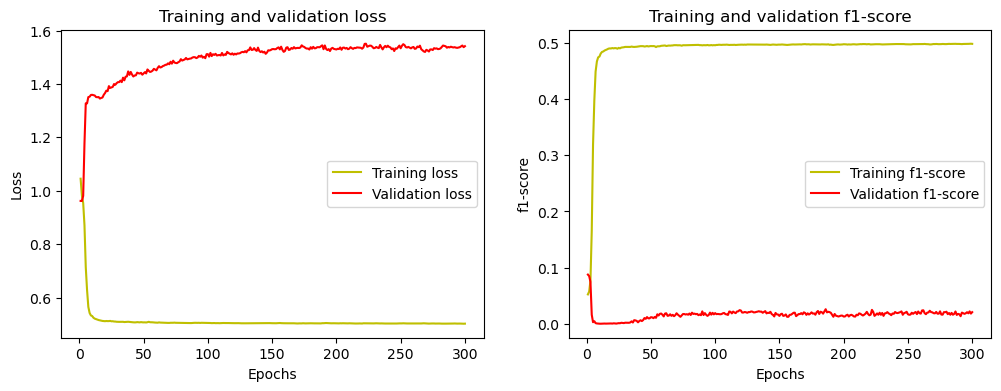

In [22]:
acc_loss_plot(history_seresnet34)

In [23]:
# load the best model
model = tf.keras.models.load_model(fname, compile = False)

# preprocess input
preprocess_input = sm.get_preprocessing(BACKBONE)
X_test1 = preprocess_input(test1_images)
X_test2 = preprocess_input(test2_images)
print(X_test1.shape, X_test2.shape)

y_pred = model.predict([X_test1, X_test2], batch_size=8, verbose=2).squeeze(axis=-1)
# Convert predicted score to binary labels (0 or 1)
y_pred = (y_pred > 0.5).astype(int)

# Flatten arrays
y_true = test_labels.flatten()
y_pred = y_pred.flatten()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1]) # 1st row & column is class 0 & 2nd row & column is class 1

# Calculate metrics for class 1(positive) and class 0(negative)
tp = conf_matrix[1, 1]
fn = conf_matrix[1, 0]
fp = conf_matrix[0, 1]
tn = conf_matrix[0, 0]

# Compute sensitivity (true positive rate) for class 1
sensitivity = tp / (tp + fn)

# Compute specificity (true negative rate) for class 1
specificity = tn / (tn + fp)

# Compute overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred)

# Compute F1 score
f1 = f1_score(y_true, y_pred)

print()
print("Sensitivity (TPR) for class 1:", round(sensitivity, 4))
print("Specificity (TNR) for class 1:", round(specificity, 4))
print("Overall Accuracy:", round(overall_accuracy, 4))
print("F1 Score:", round(f1, 4))

(100, 512, 512, 3) (100, 512, 512, 3)
13/13 - 3s - 3s/epoch - 234ms/step

Sensitivity (TPR) for class 1: 0.0176
Specificity (TNR) for class 1: 0.9883
Overall Accuracy: 0.9212
F1 Score: 0.03
